In [1]:
import numpy as np
import math
import itertools

In [12]:
import matplotlib.pyplot as plt
from docplex.mp.model import Model

def tsp(cities, v, stay_times):
#     Finds the shortest Hamiltonian cycle for the traveling salesman problem using CPLEX.

#     Args:
#         cities (list): A list of cities, each represented as a tuple of (x, y) coordinates.
#         v (float): The velocity of the salesman.
#         stay_times (list): A list of stay times for each city, where stay_times[i] is the stay time for city i.

#     Returns:
#         tuple: A tuple containing the best route found and the total time spent.
#     n = len(cities)  # Number of cities


    # Create CPLEX model
    mdl = Model(name='TSP')

    # Create binary decision variables for the edges
    x = {(i, j): mdl.binary_var(name='x_{}_{}'.format(i, j)) for i in range(n) for j in range(n) if i != j}

    # Create continuous decision variables for the time spent
    t = mdl.continuous_var_dict(keys=range(n), name='t')

    # Set objective function
    mdl.minimize(mdl.sum(x[i, j] * (math.sqrt((cities[i][0] - cities[j][0]) ** 2 + (cities[i][1] - cities[j][1]) ** 2) / v + stay_times[j][(i+1) % n]) for i in range(n) for j in range(n) if i != j))

    # Set constraints
    # Constraint 1: Each city must be visited exactly once
    for i in range(n):
        mdl.add_constraint(mdl.sum(x[i, j] for j in range(n) if i != j) == 1)

    # Constraint 2: Each city must be left exactly once
    for i in range(n):
        mdl.add_constraint(mdl.sum(x[j, i] for j in range(n) if i != j) == 1)
        
    # Subtour elimination constraints
    for k in range(2, n):
        for S in itertools.combinations(range(n), k):
            mdl.add_constraint(mdl.sum(x[i, j] for i in S for j in S if i != j) <= k-1)
    
    # Constraint 3: Time spent must be greater than or equal to stay time
    for i in range(n):
        mdl.add_constraint(t[i] >= stay_times[i][0])
        mdl.add_constraint(t[i] >= stay_times[i][1] + x[i, (i+1) % n] * (math.sqrt((cities[i][0] - cities[(i+1) % n][0]) ** 2 + (cities[i][1] - cities[(i+1) % n][1]) ** 2) / v))

    # Constraint 4: Time spent must be greater than or equal to 0
    for i in range(n):
        mdl.add_constraint(t[i] >= 0)
    
    # Constraint 5: Salesman cannot return to the origin city
    mdl.add_constraint(mdl.sum(x[(n-1), j] for j in range(n) if j != (n-1)) <= 1)

    # Solve the model
    mdl.solve()

   
    # Extract the solution
    best_route = []
    for i in range(n):
        for j in range(n):
            if i != j and x[i, j].solution_value <= 1:
                best_route.append(i)
    total_time = sum(stay_times[i][(i+1) % 7] + x[i, (i+1) % n].solution_value * (math.sqrt((cities[i][0] - cities[(i+1) % n][0]) ** 2 + (cities[i][1] - cities[(i+1) % n][1]) ** 2) / v) for i in range(n))
    solution = mdl.solve(log_output=True)


    return best_route, total_time,solution


def plot_route(cities, route):
    """
    Plots the route found by the TSP solver.

    Args:
        cities (list): A list of cities, each represented as a tuple of (x, y) coordinates.
        route (list): A list of city indices representing the route found.
    """
    # Extract x and y coordinates of cities
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]

    # Plot the cities as points with numbering
    for i in range(len(cities)):
        plt.scatter(x[i], y[i], color='red', label='City {}'.format(i+1))
        plt.text(x[i], y[i], str(i+1), ha='center', va='center', color='black', fontsize=12)

    # Plot the arrows for the route
    for i in range(len(route)):
        plt.quiver(x[route[i]], y[route[i]], x[route[(i + 1) % len(route)]] - x[route[i]],
                   y[route[(i + 1) % len(route)]] - y[route[i]], angles='xy', scale_units='xy', scale=1,
                   color='blue', linewidth=2, label='Route' if i == 0 else None)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Traveling Salesman Problem Solution')
    plt.legend()
    plt.show()



# Read input

with open('input.txt', 'r') as file:
    # Read the first line to get the number of points and velocity
    line = file.readline()
    n, v = map(int, line.strip().split())

    # Create a list to store the coordinates of points
    cities = []
    stay_times=[]
    x_values = []
    y_values = []

    # Read the rest of the lines for point coordinates
    lines = file.readlines()
    for line in lines:
        # Split the line by spaces
        x, y, t1, t2, t3, t4, t5, t6, t7 = map(int, line.strip().split())
        cities.append((x, y))
#         x = int(items[0])
#         y = int(items[1])
        stay_times.append([t1, t2, t3, t4, t5, t6, t7])
        x_values.append(x)
        y_values.append(y)

route, total_time, solution = tsp(cities, v, stay_times)
print("Best route:", route)
print("Total time spent:", total_time)
print(solution)

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1

Root node processing (before b&c):
  Real time             =    0.00 sec. (0.00 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.00 ticks)
Best route: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]
Total time spent: 45.289209676074286
solution for: TSP
objective: 199.882
x_0_1=1
x_1_2=1
x_2_4=1
x_3_0=1
x_4_3=1
t_0=30.000
t_1=7.000
t_2=2.000
t_3=4.000
t_4=4.000



In [6]:
cities[1][1]

68

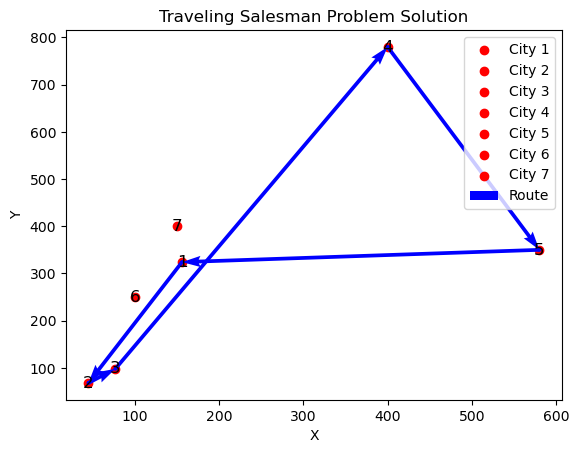

In [13]:
plot_route(cities, route)
